In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as sp
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as sp
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

def generate_dcsbm_bipartite(n_users=100, n_items=150, n_user_blocks=2, n_item_blocks=2, 
                             alpha=2.1, min_degree=3, sparsity=0.8, 
                             block_connection_strength=0.8):
    """
    Generate a bipartite degree-corrected stochastic block model
    
    Parameters:
    -----------
    n_users : int
        Number of user nodes
    n_items : int
        Number of item nodes
    n_user_blocks : int
        Number of user blocks
    n_item_blocks : int
        Number of item blocks
    alpha : float
        Power law exponent for degree distribution
    min_degree : int
        Minimum degree for nodes
    sparsity : float
        Overall sparsity of the network
    block_connection_strength : float
        Strength of within-block connections versus between-block
        
    Returns:
    --------
    G : networkx.Graph
        Bipartite graph
    user_memberships : numpy.ndarray
        Block memberships for user nodes
    item_memberships : numpy.ndarray
        Block memberships for item nodes
    """
    # Assign block memberships
    user_memberships = np.repeat(np.arange(n_user_blocks), n_users // n_user_blocks)
    if len(user_memberships) < n_users:  # Handle case where n_users is not divisible by n_user_blocks
        user_memberships = np.append(user_memberships, np.zeros(n_users - len(user_memberships), dtype=int))
        
    item_memberships = np.repeat(np.arange(n_item_blocks), n_items // n_item_blocks)
    if len(item_memberships) < n_items:
        item_memberships = np.append(item_memberships, np.zeros(n_items - len(item_memberships), dtype=int))
    
    # Generate power law degree sequence for items
    item_degrees = np.zeros(n_items, dtype=int)
    for b in range(n_item_blocks):
        block_indices = np.where(item_memberships == b)[0]
        block_size = len(block_indices)
        
        # Generate power law distribution
        x = np.arange(min_degree, min_degree + block_size)
        p = x ** (-alpha)
        p /= p.sum()
        
        # Assign degrees
        degrees = np.random.choice(x, size=block_size, p=p, replace=True)
        item_degrees[block_indices] = degrees
    
    # Create connectivity matrix between blocks
    block_matrix = np.ones((n_user_blocks, n_item_blocks)) * (1 - block_connection_strength)
    np.fill_diagonal(block_matrix, block_connection_strength)
    
    # Create empty adjacency matrix
    adj = np.zeros((n_users + n_items, n_users + n_items))
    
    # Connect users to items based on block memberships and power law degrees
    for i in range(n_users):
        user_block = user_memberships[i]
        
        for j in range(n_items):
            item_block = item_memberships[j]
            
            # Probability based on block relationship
            p_connect = block_matrix[user_block, item_block]
            
            # Adjust for item degree (normalized)
            p_connect *= item_degrees[j] / np.mean(item_degrees)
            
            # Apply sparsity
            p_connect *= (1 - sparsity)
            
            if np.random.random() < p_connect:
                adj[i, n_users + j] = 1
                adj[n_users + j, i] = 1
    
    # Create networkx graph
    G = nx.Graph()
    
    # Add nodes with attributes
    for i in range(n_users):
        G.add_node(i, bipartite=0, block=user_memberships[i])
    
    for j in range(n_items):
        G.add_node(n_users + j, bipartite=1, block=item_memberships[j])
    
    # Add edges
    for i in range(n_users):
        for j in range(n_items):
            if adj[i, n_users + j] == 1:
                G.add_edge(i, n_users + j)
    
    return G, user_memberships, item_memberships

def visualize_bipartite_network(G, user_memberships, item_memberships, n_users):
    """
    Visualize the bipartite network with nodes colored by block membership
    """
    plt.figure(figsize=(12, 8))
    
    # Create position layout
    pos = nx.bipartite_layout(G, nodes=[i for i in range(n_users)])
    
    # Color nodes by block membership
    node_colors = []
    for node in G.nodes():
        if node < n_users:  # User node
            node_colors.append('C' + str(user_memberships[node]))
        else:  # Item node
            node_colors.append('C' + str(item_memberships[node - n_users] + 2))  # +2 to use different colors
    
    # Draw the network
    nx.draw_networkx(G, pos=pos, node_color=node_colors, with_labels=False, 
                     node_size=50, alpha=0.8, width=0.5)
    
    # Create legend
    user_blocks = np.unique(user_memberships)
    item_blocks = np.unique(item_memberships)
    
    user_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='C' + str(b), 
                              markersize=10, label=f'User Block {b}') for b in user_blocks]
    item_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='C' + str(b + 2), 
                              markersize=10, label=f'Item Block {b}') for b in item_blocks]
    
    plt.legend(handles=user_handles + item_handles, loc='upper right')
    plt.title('Bipartite Degree-Corrected Stochastic Block Model')
    plt.tight_layout()
    plt.show()

def spectral_embedding(G, n_users, n_items, embedding_dim=2, reg_param=0.1):
    """
    Compute regularized spectral embeddings for the bipartite graph
    
    Parameters:
    -----------
    G : networkx.Graph
        Bipartite graph
    n_users : int
        Number of user nodes
    n_items : int
        Number of item nodes
    embedding_dim : int
        Dimension of embeddings
    reg_param : float
        Regularization parameter
        
    Returns:
    --------
    user_embeddings : numpy.ndarray
        Embeddings for user nodes
    item_embeddings : numpy.ndarray
        Embeddings for item nodes
    """
    # Get adjacency matrix
    A = nx.to_scipy_sparse_matrix(G).astype(float)
    
    # Add regularization to diagonal
    A_reg = A + reg_param * sp.eye(A.shape[0])
    
    # Compute normalized Laplacian
    D_inv_sqrt = sp.diags(1.0 / np.sqrt(A_reg.sum(axis=1).A1))
    L_norm = D_inv_sqrt @ A @ D_inv_sqrt
    
    # Compute eigendecomposition
    eigvals, eigvecs = sp.linalg.eigsh(L_norm, k=embedding_dim, which='LA')
    
    # Sort by eigenvalues in descending order
    idx = np.argsort(-eigvals)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
#     # Exclude the first eigenvector (corresponds to constant vector)
#     embeddings = eigvecs[:, 1:embedding_dim+1]
    embeddings = eigvecs
    
    # Split into user and item embeddings
    user_embeddings = embeddings[:n_users]
    item_embeddings = embeddings[n_users:n_users+n_items]
    
    return user_embeddings, item_embeddings

class BPR(nn.Module):
    """
    Bayesian Personalized Ranking (BPR) model for learning embeddings
    """
    def __init__(self, n_users, n_items, embedding_dim=2):
        super(BPR, self).__init__()
        self.user_embeddings = nn.Embedding(n_users, embedding_dim)
        self.item_embeddings = nn.Embedding(n_items, embedding_dim)
        
        # Initialize embeddings
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)
        
    def forward(self, user_idx, pos_item_idx, neg_item_idx):
        # Get embeddings
        user_emb = self.user_embeddings(user_idx)
        pos_item_emb = self.item_embeddings(pos_item_idx)
        neg_item_emb = self.item_embeddings(neg_item_idx)
        
        # Compute scores
        pos_score = torch.sum(user_emb * pos_item_emb, dim=1)
        neg_score = torch.sum(user_emb * neg_item_emb, dim=1)
        
        # BPR loss
        loss = -torch.mean(torch.log(torch.sigmoid(pos_score - neg_score)))
        
        return loss
    
    def get_embeddings(self):
        return self.user_embeddings.weight.detach().numpy(), self.item_embeddings.weight.detach().numpy()

def train_bpr(G, n_users, n_items, embedding_dim=2, lr=0.01, n_epochs=200, batch_size=64):
    """
    Train BPR model on the bipartite graph
    
    Parameters:
    -----------
    G : networkx.Graph
        Bipartite graph
    n_users : int
        Number of user nodes
    n_items : int
        Number of item nodes
    embedding_dim : int
        Dimension of embeddings
    lr : float
        Learning rate
    n_epochs : int
        Number of training epochs
    batch_size : int
        Batch size
        
    Returns:
    --------
    user_embeddings : numpy.ndarray
        Embeddings for user nodes
    item_embeddings : numpy.ndarray
        Embeddings for item nodes
    """
    # Create edge list
    edge_list = list(G.edges())
    
    # Create positive samples (user, item) pairs
    pos_samples = []
    for u, v in edge_list:
        if u < n_users:  # Ensure u is user, v is item
            pos_samples.append((u, v - n_users))
        else:  # Otherwise, swap
            pos_samples.append((v, u - n_users))
    
    pos_samples = np.array(pos_samples)
    
    # Initialize BPR model
    model = BPR(n_users, n_items, embedding_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in tqdm(range(n_epochs), desc="Training BPR"):
        # Shuffle positive samples
        np.random.shuffle(pos_samples)
        
        # Process in batches
        for i in range(0, len(pos_samples), batch_size):
            batch = pos_samples[i:i+batch_size]
            users = batch[:, 0]
            pos_items = batch[:, 1]
            
            # Sample negative items
            neg_items = np.random.randint(0, n_items, size=len(batch))
            
            # Convert to tensors
            user_tensor = torch.LongTensor(users)
            pos_item_tensor = torch.LongTensor(pos_items)
            neg_item_tensor = torch.LongTensor(neg_items)
            
            # Compute loss
            optimizer.zero_grad()
            loss = model(user_tensor, pos_item_tensor, neg_item_tensor)
            loss.backward()
            optimizer.step()
    
    # Get final embeddings
    user_embeddings, item_embeddings = model.get_embeddings()
    
    return user_embeddings, item_embeddings

def visualize_embeddings(user_embeddings, item_embeddings, user_memberships, item_memberships, method_name):
    """
    Enhanced visualization of the learned embeddings
    """
    # Concatenate all embeddings and memberships
    all_embeddings = np.vstack([user_embeddings, item_embeddings])
    all_memberships = np.concatenate([user_memberships, item_memberships + 2])  # +2 to use different colors for item blocks
    
    # For higher dimensional embeddings, use t-SNE to project to 2D
    if all_embeddings.shape[1] > 2:
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_embeddings)-1))
        all_embeddings_2d = tsne.fit_transform(all_embeddings)
        projection_method = "t-SNE projection"
    else:
        all_embeddings_2d = all_embeddings
        projection_method = "2D embedding"
    
    # Create figure with two subplots - one for all nodes, one separating users and items
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Define better color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Define markers and sizes
    user_marker = 'o'
    item_marker = 's'
    marker_size = 100
    
    # Create masks for each block
    user_block_0_mask = (all_memberships == 0)
    user_block_1_mask = (all_memberships == 1)
    item_block_0_mask = (all_memberships == 2)
    item_block_1_mask = (all_memberships == 3)
    
    # PLOT 1: All nodes together
    ax1.scatter(all_embeddings_2d[user_block_0_mask, 0], all_embeddings_2d[user_block_0_mask, 1], 
               marker=user_marker, c=colors[0], label='User Block 0', s=marker_size, alpha=0.8, edgecolors='k', linewidths=0.5)
    ax1.scatter(all_embeddings_2d[user_block_1_mask, 0], all_embeddings_2d[user_block_1_mask, 1], 
               marker=user_marker, c=colors[1], label='User Block 1', s=marker_size, alpha=0.8, edgecolors='k', linewidths=0.5)
    ax1.scatter(all_embeddings_2d[item_block_0_mask, 0], all_embeddings_2d[item_block_0_mask, 1], 
               marker=item_marker, c=colors[2], label='Item Block 0', s=marker_size, alpha=0.8, edgecolors='k', linewidths=0.5)
    ax1.scatter(all_embeddings_2d[item_block_1_mask, 0], all_embeddings_2d[item_block_1_mask, 1], 
               marker=item_marker, c=colors[3], label='Item Block 1', s=marker_size, alpha=0.8, edgecolors='k', linewidths=0.5)
    
    ax1.legend(fontsize=12)
    ax1.set_title(f'{method_name}\nAll Nodes ({projection_method})', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_xlabel("Dimension 1", fontsize=12)
    ax1.set_ylabel("Dimension 2", fontsize=12)
    
    # PLOT 2: Separate scatter plots for users and items
    # User embeddings
    n_users = len(user_memberships)
    user_embeddings_2d = all_embeddings_2d[:n_users]
    user_block_0_mask_only = (user_memberships == 0)
    user_block_1_mask_only = (user_memberships == 1)
    
    # Item embeddings
    item_embeddings_2d = all_embeddings_2d[n_users:]
    item_block_0_mask_only = (item_memberships == 0)
    item_block_1_mask_only = (item_memberships == 1)
    
    ax2.scatter(user_embeddings_2d[user_block_0_mask_only, 0], user_embeddings_2d[user_block_0_mask_only, 1], 
               marker=user_marker, c=colors[0], label='User Block 0', s=marker_size, alpha=0.8, edgecolors='k', linewidths=0.5)
    ax2.scatter(user_embeddings_2d[user_block_1_mask_only, 0], user_embeddings_2d[user_block_1_mask_only, 1], 
               marker=user_marker, c=colors[1], label='User Block 1', s=marker_size, alpha=0.8, edgecolors='k', linewidths=0.5)
    ax2.scatter(item_embeddings_2d[item_block_0_mask_only, 0], item_embeddings_2d[item_block_0_mask_only, 1], 
               marker=item_marker, c=colors[2], label='Item Block 0', s=marker_size, alpha=0.8, edgecolors='k', linewidths=0.5)
    ax2.scatter(item_embeddings_2d[item_block_1_mask_only, 0], item_embeddings_2d[item_block_1_mask_only, 1], 
               marker=item_marker, c=colors[3], label='Item Block 1', s=marker_size, alpha=0.8, edgecolors='k', linewidths=0.5)
    
    # Add convex hulls around each block to emphasize clusters
    from scipy.spatial import ConvexHull
    
    def plot_convex_hull(points, ax, color, alpha=0.2):
        if len(points) >= 3:  # Need at least 3 points for a convex hull
            hull = ConvexHull(points)
            for simplex in hull.simplices:
                ax.plot(points[simplex, 0], points[simplex, 1], color=color, alpha=0.7)
            # Fill the hull
            hull_points = points[hull.vertices]
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=alpha)
    
    # Plot convex hulls
    if np.sum(user_block_0_mask_only) >= 3:
        plot_convex_hull(user_embeddings_2d[user_block_0_mask_only], ax2, colors[0])
    if np.sum(user_block_1_mask_only) >= 3:
        plot_convex_hull(user_embeddings_2d[user_block_1_mask_only], ax2, colors[1])
    if np.sum(item_block_0_mask_only) >= 3:
        plot_convex_hull(item_embeddings_2d[item_block_0_mask_only], ax2, colors[2])
    if np.sum(item_block_1_mask_only) >= 3:
        plot_convex_hull(item_embeddings_2d[item_block_1_mask_only], ax2, colors[3])
    
    ax2.legend(fontsize=12)
    ax2.set_title(f'{method_name}\nUsers and Items with Cluster Boundaries ({projection_method})', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_xlabel("Dimension 1", fontsize=12)
    ax2.set_ylabel("Dimension 2", fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Add a third visualization with evaluation metrics
    plt.figure(figsize=(10, 6))
    
    # Get ARI scores for evaluation
    user_ari, item_ari = evaluate_embeddings(user_embeddings, item_embeddings, user_memberships, item_memberships)
    avg_ari = (user_ari + item_ari) / 2
    
    # Create a bar chart with ARI scores
    labels = ['User ARI', 'Item ARI', 'Average ARI']
    scores = [user_ari, item_ari, avg_ari]
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']
    
    bars = plt.bar(labels, scores, color=colors, width=0.5, edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.ylim(0, 1.1)  # ARI is bounded between -1 and 1, but typically 0 to 1 for meaningful clusters
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Perfect Clustering')
    plt.axhline(y=0.0, color='gray', linestyle=':', alpha=0.5, label='Random Clustering')
    
    plt.title(f'Evaluation of {method_name} Clustering Quality', fontsize=16)
    plt.ylabel('Adjusted Rand Index (ARI)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

def evaluate_embeddings(user_embeddings, item_embeddings, user_memberships, item_memberships):
    """
    Evaluate how well the embeddings recover block memberships using K-means clustering
    
    Returns:
    --------
    user_ari : float
        Adjusted Rand Index for user clustering
    item_ari : float
        Adjusted Rand Index for item clustering
    """
    # Cluster user embeddings
    kmeans_users = KMeans(n_clusters=len(np.unique(user_memberships)), random_state=42)
    user_clusters = kmeans_users.fit_predict(user_embeddings)
    user_ari = adjusted_rand_score(user_memberships, user_clusters)
    
    # Cluster item embeddings
    kmeans_items = KMeans(n_clusters=len(np.unique(item_memberships)), random_state=42)
    item_clusters = kmeans_items.fit_predict(item_embeddings)
    item_ari = adjusted_rand_score(item_memberships, item_clusters)
    
    return user_ari, item_ari

def run_experiment(n_users=100, n_items=150, embedding_dim=2):
    """
    Run the complete experiment
    """
    print("Generating bipartite degree-corrected stochastic block model...")
    G, user_memberships, item_memberships = generate_dcsbm_bipartite(
        n_users=n_users, 
        n_items=n_items, 
        n_user_blocks=2, 
        n_item_blocks=2,
        sparsity=0.9
    )
    
    print(f"Network generated: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    # Visualize the network
    visualize_bipartite_network(G, user_memberships, item_memberships, n_users)
    
    print("\nComputing spectral embeddings...")
    user_spectral, item_spectral = spectral_embedding(G, n_users, n_items, embedding_dim=embedding_dim)
    
    print("\nTraining BPR embeddings...")
    user_bpr, item_bpr = train_bpr(G, n_users, n_items, embedding_dim=embedding_dim)
    
    # Visualize embeddings
    print("\nVisualizing spectral embeddings...")
    visualize_embeddings(user_spectral, item_spectral, user_memberships, item_memberships, "Spectral Embedding")
    
    print("\nVisualizing BPR embeddings...")
    visualize_embeddings(user_bpr, item_bpr, user_memberships, item_memberships, "BPR Embedding")
    
    # Evaluate embeddings
    print("\nEvaluating embeddings...")
    user_spectral_ari, item_spectral_ari = evaluate_embeddings(user_spectral, item_spectral, 
                                                               user_memberships, item_memberships)
    user_bpr_ari, item_bpr_ari = evaluate_embeddings(user_bpr, item_bpr, 
                                                    user_memberships, item_memberships)
    
    print("\nResults:")
    print(f"Spectral Embedding - User ARI: {user_spectral_ari:.4f}, Item ARI: {item_spectral_ari:.4f}, Average: {(user_spectral_ari + item_spectral_ari)/2:.4f}")
    print(f"BPR Embedding - User ARI: {user_bpr_ari:.4f}, Item ARI: {item_bpr_ari:.4f}, Average: {(user_bpr_ari + item_bpr_ari)/2:.4f}")
    
    # Compare results
    if (user_spectral_ari + item_spectral_ari) > (user_bpr_ari + item_bpr_ari):
        print("\nConclusion: Spectral embeddings better recover block memberships")
    else:
        print("\nConclusion: BPR embeddings better recover block memberships")

Generating bipartite degree-corrected stochastic block model...
Network generated: 250 nodes, 774 edges


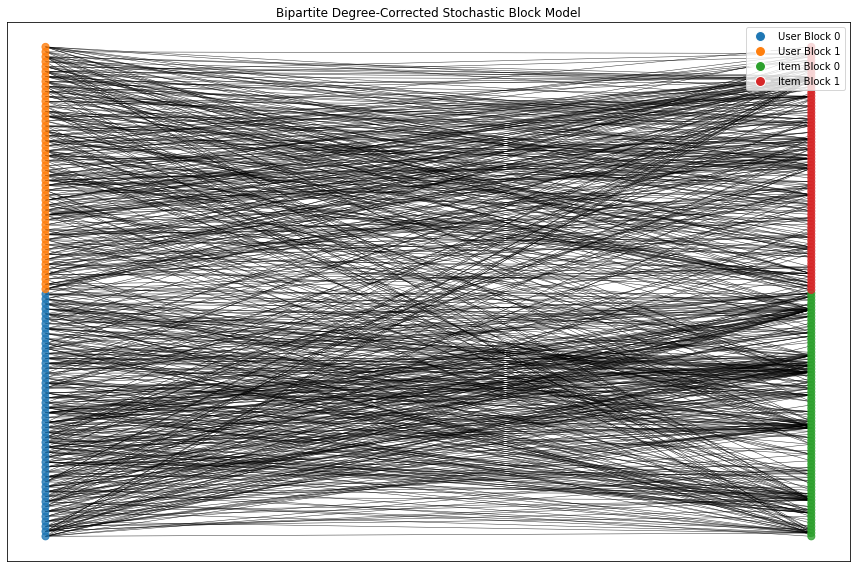


Computing spectral embeddings...

Training BPR embeddings...


Training BPR: 100%|██████████| 200/200 [00:01<00:00, 131.92it/s]



Visualizing spectral embeddings...


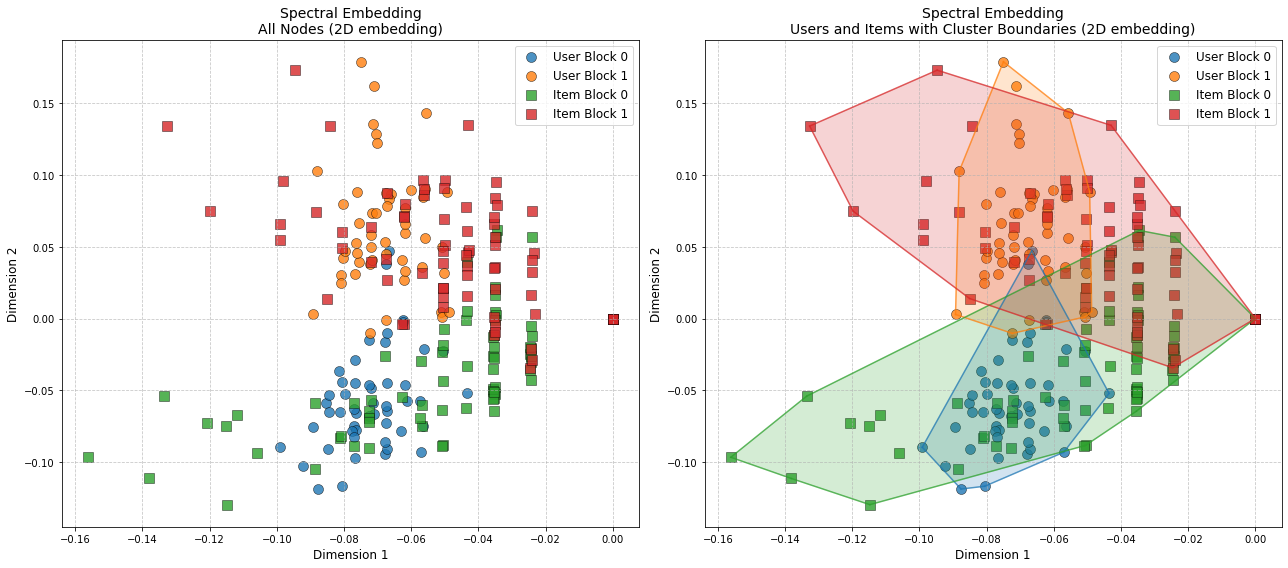

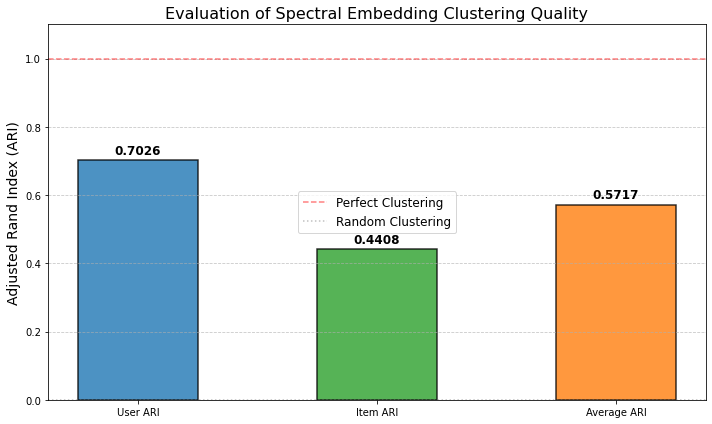


Visualizing BPR embeddings...


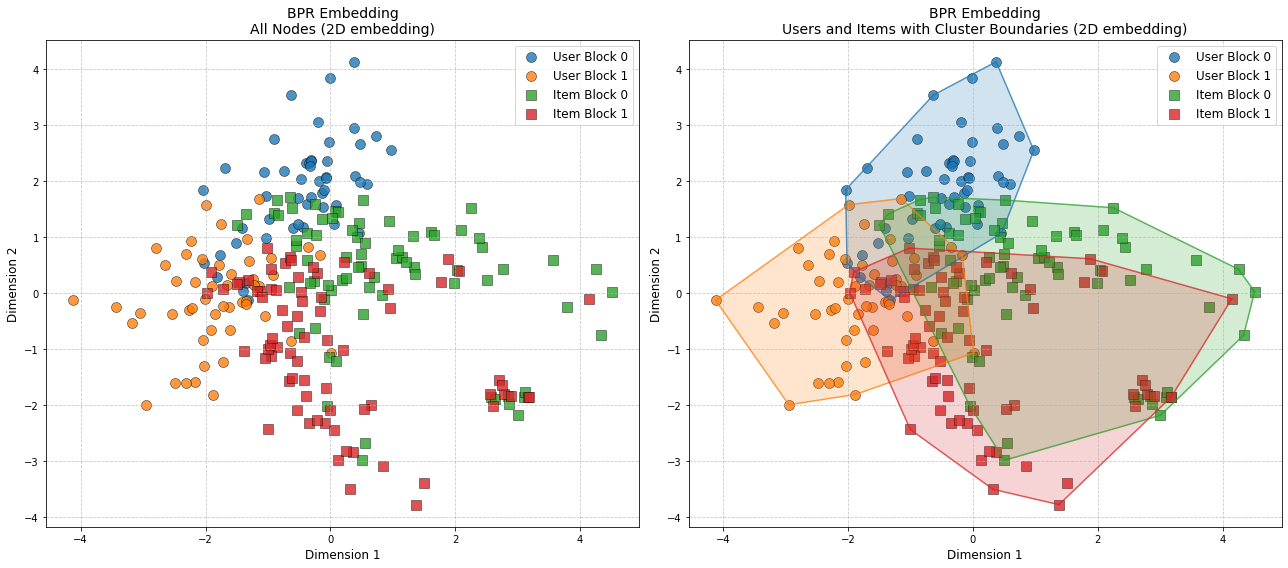

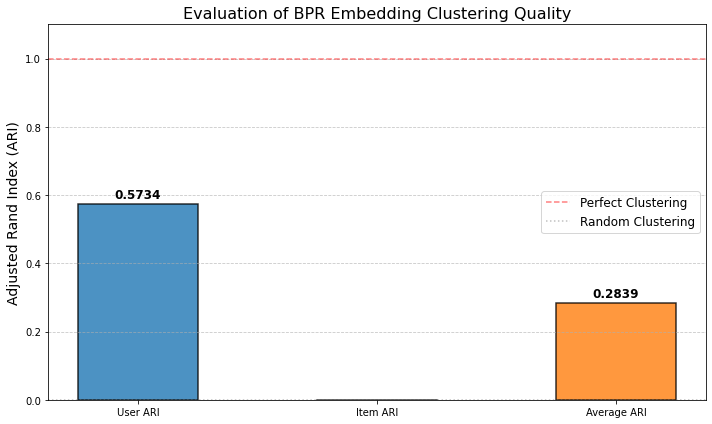


Evaluating embeddings...

Results:
Spectral Embedding - User ARI: 0.7026, Item ARI: 0.4408, Average: 0.5717
BPR Embedding - User ARI: 0.5734, Item ARI: -0.0056, Average: 0.2839

Conclusion: Spectral embeddings better recover block memberships


In [15]:
run_experiment(n_users=100, n_items=150, embedding_dim=2)